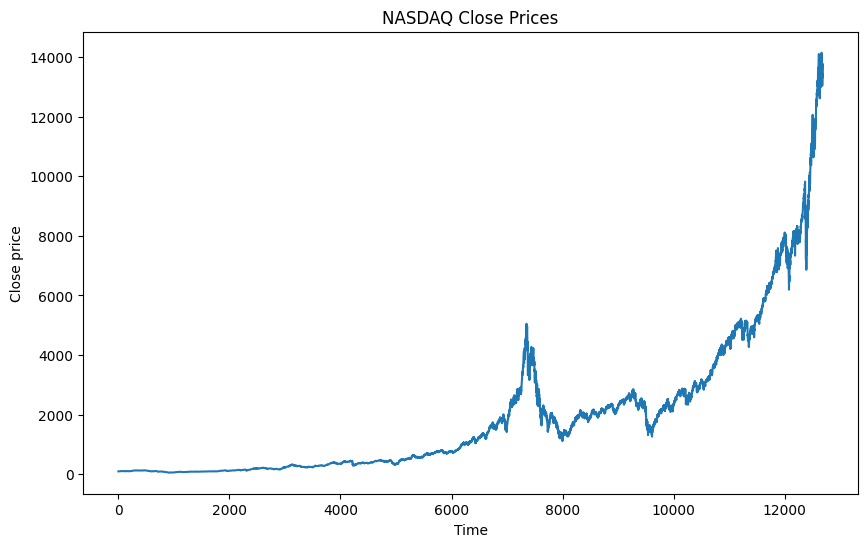

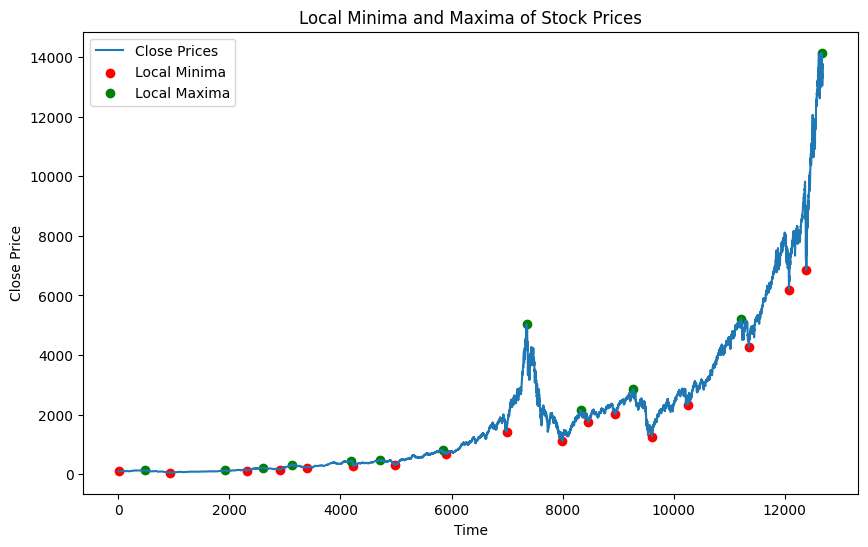

Number of local extrema: 29 Number of data points: 12690
Step  1


In [ ]:
"""
Dataset Infos:
- Includes multiple companies stock data including Open, Clode, High, Low, Volume
- Dates as timestamps
=> Requires nonlinearity to capture the stock price movements
"""
"""
Main idea:
Trying to predict close prices (feature) for NASDAQ
"""

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
from qiskit.providers.basic_provider import BasicSimulator  
from qiskit_algorithms.optimizers import COBYLA # From Qiskit tutorial
from qiskit.circuit import Parameter, ParameterVector
from qiskit.providers.basic_provider import BasicSimulator
from scipy.signal import argrelextrema

np.random.seed(42)


# parameters for encoding function phi and encoding function definitions (as in the paper "Input Redundancy for Parameterized Quantum Circuits" described)
a = 1
b = 0

def phi_identity(x): return x
def phi_arcsin(x): return np.arcsin((a*x + b) / (2 * np.pi))


# load dataset
stock_data = pd.read_csv('C:/Users/lucam/OneDrive/Desktop/ZHAW/Semester_5/QI/Project/git/Quantum-Computing-Data-Repetition/src/experiments/serial_data/data/indexData.csv')  
nasdaq_data = stock_data[stock_data['Index'] == 'IXIC']
close_prices = nasdaq_data['Close'].values  
x = np.arange(len(close_prices)) 
plt.figure(figsize=(10, 6))
plt.plot(x, close_prices)
plt.title("NASDAQ Close Prices")
plt.xlabel("Time")
plt.ylabel("Close price")
plt.show()


# analysis for lower bound
order = 200
local_minima = argrelextrema(close_prices, np.less, order=order)[0]
local_maxima = argrelextrema(close_prices, np.greater, order=order)[0]
plt.figure(figsize=(10, 6))
plt.plot(close_prices, label="Close Prices")
plt.scatter(local_minima, close_prices[local_minima], marker='o', color='red', label="Local Minima")
plt.scatter(local_maxima, close_prices[local_maxima], marker='o', color='green', label="Local Maxima")
plt.title("Local Minima and Maxima of Stock Prices")
plt.xlabel("Time")
plt.ylabel("Close Price")
plt.legend()
plt.show()
num_extrema = len(local_minima) + len(local_maxima)
print(f"Number of local extrema: {num_extrema}", f"Number of data points: {len(close_prices)}")

# loss functions for training
def square_loss(targets, predictions):
    loss = 0
    for t, p in zip(targets, predictions):
        loss = loss + (t - p) ** 2
    loss = loss / len(targets)
    return 0.5 * loss


# target function which the quantum model has to fit
scaling = 2 * np.pi 
def target_function(x): return close_prices[int(x)] / scaling


# serial quantum model
def serial_quantum_model(weights, x=None):
    weights_reshaped = weights.reshape(-1, 3)
    
    # 1 qubit, 1 classical bit
    qr = QuantumRegister(1, 'q')
    cr = ClassicalRegister(1, 'c')
    qc = QuantumCircuit(qr, cr)
    
    # data encoding circuit block (S(x))
    encoded_x = phi_arcsin(x)
    qc.rx(scaling * encoded_x, qr[0])
    
    # trainable circuit block (U(theta))
    # rotation around X, Y, and Z axes for trainable parameters
    for theta in weights_reshaped[:-1]:
        qc.rx(theta[0], qr[0])
        qc.ry(theta[1], qr[0])
        qc.rz(theta[2], qr[0])
        qc.rx(scaling * encoded_x, qr[0])  # after each rotation apply the data encoding again

    theta = weights_reshaped[-1]
    qc.rx(theta[0], qr[0])
    qc.ry(theta[1], qr[0])
    qc.rz(theta[2], qr[0])

    qc.draw('mpl')
    qc.measure(qr[0], cr[0])

    simulator = BasicSimulator()
    result = simulator.run(qc, shots=1024).result()

    counts = result.get_counts(qc)
    return counts.get('0', 0) / 1024


# cost function for training
def cost(weights, x, y):
    predictions = [serial_quantum_model(weights, x=x_) for x_ in x]
    loss = square_loss(y, predictions)
    reg = 0.01 * np.sum(weights**2) 
    return loss + reg


max_steps = 60
opt = COBYLA(maxiter=20, rhobeg=0.01)
batch_size = 25


r = 3
weights = np.random.uniform(low=-0.1, high=0.1, size=(r + 1, 3)) # weights = 2 * np.pi * np.random.random(size=(r + 1, 3))  
weights_flat = weights.ravel()

x_normalized = (x - np.min(x)) / (np.max(x) - np.min(x))  
target_y = (close_prices - np.min(close_prices)) / (np.max(close_prices) - np.min(close_prices))  


cst = [cost(weights_flat, x_normalized, target_y)] 


# training loop
for step in range(max_steps):
    print("Step {0:2}".format(step + 1))

    batch_index = np.random.randint(0, len(x), (batch_size,))
    x_batch = x_normalized[batch_index]
    y_batch = target_y[batch_index]

    result = opt.minimize(lambda w: cost(w, x_batch, y_batch), weights_flat)
    weights_flat = result.x  

    c = cost(weights_flat, x_normalized, target_y)
    cst.append(c)

    if (step + 1) % 10 == 0:
        print("Cost at step {0:3}: {1}".format(step + 1, c))


plt.figure(figsize=(10, 6))
plt.plot(cst)
plt.title("Cost function progression over training steps")
plt.xlabel("Step")
plt.ylabel("Cost")
plt.show()

predictions = [serial_quantum_model(weights_flat, x=x_) for x_ in x_normalized]

plt.figure(figsize=(10, 6))
plt.plot(x, target_y, c='black', label="Target")
plt.plot(x, predictions, c='blue', linestyle='--', label="Prediction")
plt.title("Predictions vs. Target")
plt.xlabel("Time")
plt.ylabel("Close price")
plt.show()